In [33]:
#项目讲解链接：https://www.bilibili.com/video/BV1Nw4m1D75E/?spm_id_from=333.999.0.0&vd_source=6528929ff3772e61e9f5baf9b8ab1e64
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from model.SimpleCNN import *
from model.KAN import KAN_Convolution_Network


In [14]:
# 定义数据转换操作，将图像转换为Tensor并进行归一化处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize((0.5,), (0.5,))  # 归一化，将图像数据的每个通道归一化到均值为0.5，标准差为0.5
])
# 加载MNIST训练集，并应用定义好的数据转换操作
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
# 加载MNIST测试集，并应用定义好的数据转换操作
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)
# 定义训练数据的DataLoader，用于批量加载数据
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
# 定义测试数据的DataLoader，用于批量加载数据
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [15]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    训练模型一个epoch

    参数:
        model: 神经网络模型
        device: 使用的设备（cuda或cpu）
        train_loader: 训练数据的DataLoader
        optimizer: 优化器（例如SGD）
        epoch: 当前的epoch数
        criterion: 损失函数（例如CrossEntropy）

    返回:
        avg_loss: 当前epoch的平均损失
    """
    model.to(device)  # 将模型加载到指定设备上
    model.train()  # 设置模型为训练模式
    train_loss = 0  # 初始化训练损失
    # 分批处理图像
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)  # 将数据和目标加载到指定设备上    
        optimizer.zero_grad()  # 重置优化器的梯度
        output = model(data)  # 将数据前向传递通过模型层   
        loss = criterion(output, target)  # 计算损失
        train_loss += loss.item()  # 累加损失     
        loss.backward()  # 反向传播
        optimizer.step()  # 优化器更新参数
        
    avg_loss = train_loss / (batch_idx+1)  # 计算当前epoch的平均损失
    return avg_loss

def test(model, device, test_loader, criterion):
    """
    测试模型

    参数:
        model: 神经网络模型
        device: 使用的设备（cuda或cpu）
        test_loader: 测试数据的DataLoader
        criterion: 损失函数（例如CrossEntropy）

    返回:
        test_loss: 测试集上的平均损失
        accuracy: 模型在测试集上的准确率
        precision: 模型在测试集上的精确率
        recall: 模型在测试集上的召回率
        f1: 模型在测试集上的F1分数
    """
    model.eval()  # 设置模型为评估模式
    test_loss = 0  # 初始化测试损失
    correct = 0  # 初始化正确预测计数
    all_targets = []  # 初始化所有真实标签列表
    all_predictions = []  # 初始化所有预测标签列表
    
    with torch.no_grad():  # 在不计算梯度的上下文中
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # 将数据和目标加载到指定设备上    
            output = model(data)  # 获取预测结果
            test_loss += criterion(output, target).item()  # 计算并累加损失
            _, predicted = torch.max(output.data, 1)  # 获取预测的类别
            correct += (target == predicted).sum().item()  # 计算正确预测的数量
            all_targets.extend(target.view_as(predicted).cpu().numpy())  # 收集所有真实标签
            all_predictions.extend(predicted.cpu().numpy())  # 收集所有预测标签

    test_loss /= len(test_loader.dataset)  # 归一化测试损失
    accuracy = correct / len(test_loader.dataset)  # 计算准确率
    return test_loss, accuracy


In [16]:
def train_and_test_models(model, device, train_loader, test_loader, optimizer, criterion, epochs, scheduler):
    """
    训练并测试模型

    参数:
        model: 神经网络模型
        device: 使用的设备（cuda或cpu）
        train_loader: 训练数据的DataLoader
        test_loader: 测试数据的DataLoader
        optimizer: 优化器（例如SGD）
        criterion: 损失函数（例如CrossEntropy）
        epochs: 训练的epoch数
        scheduler: 学习率调度器

    返回:
        all_train_loss: 每个epoch的平均训练损失列表
        all_test_loss: 每个epoch的平均测试损失列表
        all_test_accuracy: 每个epoch的准确率列表
        all_test_precision: 每个epoch的精确率列表
        all_test_recall: 每个epoch的召回率列表
        all_test_f1: 每个epoch的F1分数列表
    """
    # 跟踪指标
    all_train_loss = []
    all_test_loss = []
    all_test_accuracy = []

    for epoch in range(1, epochs + 1):
        # 训练模型
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        all_train_loss.append(train_loss)
        # 测试模型
        test_loss, test_accuracy = test(model, device, test_loader, criterion)
        all_test_loss.append(test_loss)
        all_test_accuracy.append(test_accuracy)
        print(f'Epoch {epoch}: train_loss: {train_loss:.6f}, test_loss: {test_loss:.4f}, accuracy: {test_accuracy:.2%}')
        scheduler.step()
    model.all_test_accuracy = all_test_accuracy

    return all_train_loss, all_test_loss, all_test_accuracy


In [17]:
# 检查并设置设备 纯四层卷积
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 创建简单的CNN模型实例
model_SimpleCNN = SimpleCNN()
# 将模型移动到指定设备上
model_SimpleCNN.to(device)
# 定义优化器
optimizer_SimpleCNN = optim.AdamW(model_SimpleCNN.parameters(), lr=1e-3, weight_decay=1e-4)
# 定义学习率调度器
scheduler_SimpleCNN = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN, gamma=0.8)
# 定义损失函数
criterion_SimpleCNN = nn.CrossEntropyLoss()
# 训练并测试简单CNN模型
all_train_loss_SimpleCNN, all_test_loss_SimpleCNN, all_test_accuracy_SimpleCNN = train_and_test_models(
    model_SimpleCNN, 
    device, 
    train_loader, 
    test_loader, 
    optimizer_SimpleCNN, 
    criterion_SimpleCNN, 
    epochs=10, 
    scheduler=scheduler_SimpleCNN
)


100%|██████████| 938/938 [00:05<00:00, 157.49it/s]


Epoch 1: train_loss: 0.432571, test_loss: 0.0025, accuracy: 95.26%


100%|██████████| 938/938 [00:05<00:00, 157.54it/s]


Epoch 2: train_loss: 0.143548, test_loss: 0.0018, accuracy: 96.52%


100%|██████████| 938/938 [00:05<00:00, 158.87it/s]


Epoch 3: train_loss: 0.116358, test_loss: 0.0015, accuracy: 96.83%


100%|██████████| 938/938 [00:05<00:00, 157.72it/s]


Epoch 4: train_loss: 0.103746, test_loss: 0.0013, accuracy: 97.27%


100%|██████████| 938/938 [00:05<00:00, 156.98it/s]


Epoch 5: train_loss: 0.095698, test_loss: 0.0013, accuracy: 97.35%


100%|██████████| 938/938 [00:05<00:00, 158.58it/s]


Epoch 6: train_loss: 0.089295, test_loss: 0.0012, accuracy: 97.46%


100%|██████████| 938/938 [00:06<00:00, 155.98it/s]


Epoch 7: train_loss: 0.085485, test_loss: 0.0012, accuracy: 97.60%


100%|██████████| 938/938 [00:05<00:00, 156.63it/s]


Epoch 8: train_loss: 0.082067, test_loss: 0.0012, accuracy: 97.66%


100%|██████████| 938/938 [00:06<00:00, 155.92it/s]


Epoch 9: train_loss: 0.079759, test_loss: 0.0012, accuracy: 97.60%


100%|██████████| 938/938 [00:05<00:00, 157.24it/s]


Epoch 10: train_loss: 0.078000, test_loss: 0.0011, accuracy: 97.73%


In [36]:
from torch import nn # KAN_Cov+Linear 只更改卷积
import torch.nn.functional as F
from Kan_Convolution.KANConv import KAN_Convolutional_Layer
from Kan_Convolution.KANLinear import KANLinear

class KAN_Convolution_mlp_Network(nn.Module):
    def __init__(self,device: str = 'cpu'):
        super().__init__()
        # 创建一个KAN_Convolutional_Layer实例作为第一层卷积层
        self.conv1 = KAN_Convolutional_Layer(
            n_convs = 5, # 包含了5个卷积操作 
            kernel_size= (3,3),
            device = device
        )
        self.conv2 = KAN_Convolutional_Layer(
            n_convs = 5,
            kernel_size = (3,3),
            device = device
        )
        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )
        self.flat = nn.Flatten() 
        self.fc = nn.Linear(625, 10)
        # self.kan1 = KANLinear(
        #     784,
        #     10,
        #     grid_size=10,
        #     spline_order=3,
        #     scale_noise=0.01,
        #     scale_base=1,
        #     scale_spline=1,
        #     base_activation=nn.SiLU,
        #     grid_eps=0.02,
        #     grid_range=[0,1],
        # )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.fc(x) 
        x = F.log_softmax(x, dim=1)
        return x
# 创建KAN卷积神经网络模型实例 
model_KAN_Convolution_Network = KAN_Convolution_mlp_Network(device=device)
# 将模型移动到指定设备上
model_KAN_Convolution_Network.to(device)
# 定义优化器
optimizer_KAN_Convolution_Network = optim.AdamW(model_KAN_Convolution_Network.parameters(), lr=1e-3, weight_decay=1e-4)
# 定义学习率调度器
scheduler_KAN_Convolution_Network = optim.lr_scheduler.ExponentialLR(optimizer_KAN_Convolution_Network, gamma=0.8)
# 定义损失函数
criterion_KAN_Convolution_Network = nn.CrossEntropyLoss()
# 训练并测试KKAN卷积神经网络模型
all_train_loss_KKAN_Convolutional_Network, all_test_loss_KAN_Convolution_Network, all_test_accuracy_KAN_Convolution_Network = train_and_test_models(
    model_KAN_Convolution_Network, 
    device, 
    train_loader, 
    test_loader, 
    optimizer_KAN_Convolution_Network, 
    criterion_KAN_Convolution_Network, 
    epochs=10, 
    scheduler=scheduler_KAN_Convolution_Network
)


  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:17<00:00, 53.16it/s]


Epoch 1: train_loss: 0.335626, test_loss: 0.0019, accuracy: 96.50%


100%|██████████| 938/938 [00:17<00:00, 53.22it/s]


Epoch 2: train_loss: 0.110500, test_loss: 0.0013, accuracy: 97.34%


100%|██████████| 938/938 [00:20<00:00, 45.37it/s]


Epoch 3: train_loss: 0.082664, test_loss: 0.0011, accuracy: 98.03%


100%|██████████| 938/938 [00:23<00:00, 40.42it/s]


Epoch 4: train_loss: 0.069046, test_loss: 0.0010, accuracy: 98.00%


100%|██████████| 938/938 [00:23<00:00, 39.35it/s]


Epoch 5: train_loss: 0.061395, test_loss: 0.0009, accuracy: 98.14%


100%|██████████| 938/938 [00:22<00:00, 41.98it/s]


Epoch 6: train_loss: 0.055840, test_loss: 0.0009, accuracy: 98.10%


100%|██████████| 938/938 [00:20<00:00, 45.80it/s]


Epoch 7: train_loss: 0.052040, test_loss: 0.0009, accuracy: 98.17%


100%|██████████| 938/938 [00:22<00:00, 42.15it/s]


Epoch 8: train_loss: 0.049106, test_loss: 0.0009, accuracy: 98.18%


100%|██████████| 938/938 [00:23<00:00, 39.44it/s]


Epoch 9: train_loss: 0.046988, test_loss: 0.0008, accuracy: 98.29%


100%|██████████| 938/938 [00:22<00:00, 41.63it/s]


Epoch 10: train_loss: 0.045078, test_loss: 0.0008, accuracy: 98.24%


In [25]:
# 创建KAN卷积神经网络模型实例  KAN卷积+KAN替代线性层
model_KAN_Convolution_Network2 = KAN_Convolution_Network(device=device)
# 将模型移动到指定设备上
model_KAN_Convolution_Network2.to(device)
# 定义优化器
optimizer_KAN_Convolution_Network = optim.AdamW(model_KAN_Convolution_Network.parameters(), lr=1e-3, weight_decay=1e-4)
# 定义学习率调度器
scheduler_KAN_Convolution_Network = optim.lr_scheduler.ExponentialLR(optimizer_KAN_Convolution_Network, gamma=0.8)
# 定义损失函数
criterion_KAN_Convolution_Network = nn.CrossEntropyLoss()
# 训练并测试KKAN卷积神经网络模型
all_train_loss_KAN_Convolutional_Network2, all_test_loss_KAN_Convolution_Network2, all_test_accuracy_KAN_Convolution_Network2 = train_and_test_models(
    model_KAN_Convolution_Network2, 
    device, 
    train_loader, 
    test_loader, 
    optimizer_KAN_Convolution_Network, 
    criterion_KAN_Convolution_Network, 
    epochs=10, 
    scheduler=scheduler_KAN_Convolution_Network
)


100%|██████████| 938/938 [00:28<00:00, 33.47it/s]


Epoch 1: train_loss: 0.312648, test_loss: 0.0013, accuracy: 97.67%


100%|██████████| 938/938 [00:29<00:00, 31.91it/s]


Epoch 2: train_loss: 0.070798, test_loss: 0.0009, accuracy: 98.12%


100%|██████████| 938/938 [00:29<00:00, 32.18it/s]


Epoch 3: train_loss: 0.049869, test_loss: 0.0008, accuracy: 98.53%


100%|██████████| 938/938 [00:29<00:00, 32.05it/s]


Epoch 4: train_loss: 0.038113, test_loss: 0.0008, accuracy: 98.44%


100%|██████████| 938/938 [00:28<00:00, 32.52it/s]


Epoch 5: train_loss: 0.030945, test_loss: 0.0007, accuracy: 98.63%


100%|██████████| 938/938 [00:28<00:00, 33.46it/s]


Epoch 6: train_loss: 0.025590, test_loss: 0.0007, accuracy: 98.67%


100%|██████████| 938/938 [00:27<00:00, 34.08it/s]


Epoch 7: train_loss: 0.021873, test_loss: 0.0006, accuracy: 98.61%


100%|██████████| 938/938 [00:28<00:00, 33.37it/s]


Epoch 8: train_loss: 0.018983, test_loss: 0.0006, accuracy: 98.67%


100%|██████████| 938/938 [00:27<00:00, 33.81it/s]


Epoch 9: train_loss: 0.017007, test_loss: 0.0006, accuracy: 98.73%


100%|██████████| 938/938 [00:27<00:00, 34.04it/s]


Epoch 10: train_loss: 0.015409, test_loss: 0.0006, accuracy: 98.60%


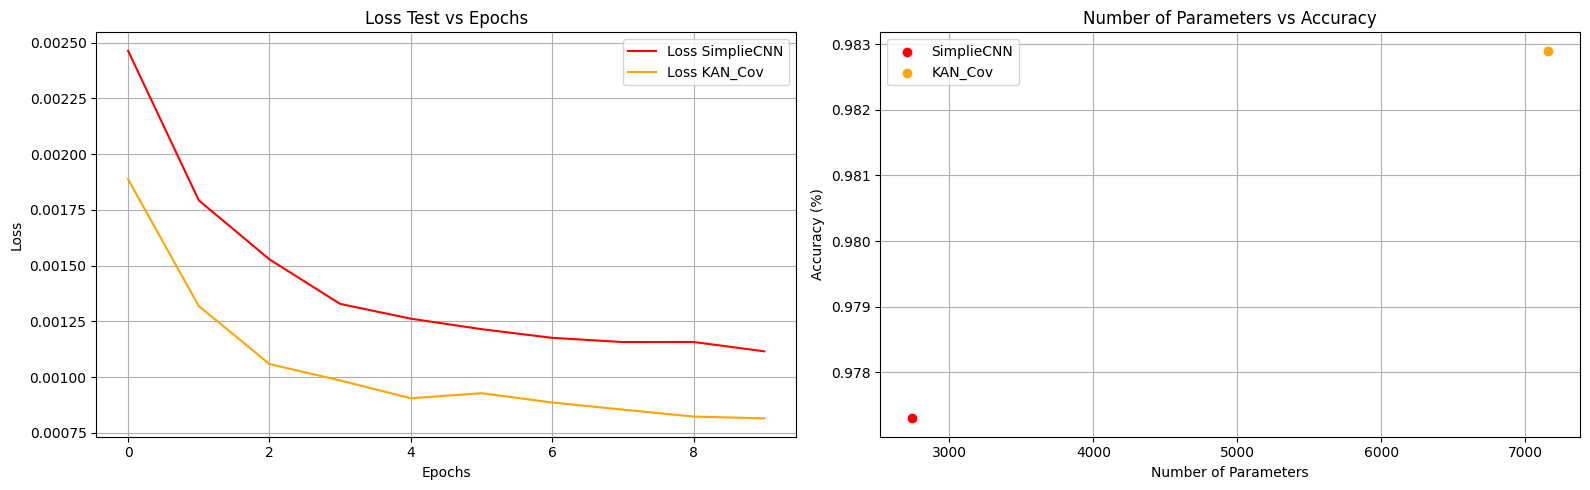

In [37]:
# 定义函数用于计算模型的可训练参数数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# 创建绘图窗口，包含两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  
# 在第一个子图中绘制测试集损失随着训练轮次的变化曲线
ax1.plot(all_test_loss_SimpleCNN, label='Loss SimplieCNN', color='red')
ax1.plot(all_test_loss_KAN_Convolution_Network, label='Loss KAN_Cov', color='orange')
ax1.set_title('Loss Test vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
# 在第二个子图中绘制模型参数数量与测试准确率的关系散点图
ax2.scatter(count_parameters(model_SimpleCNN), max(all_test_accuracy_SimpleCNN), color='red', label='SimplieCNN')
ax2.scatter(count_parameters(model_KAN_Convolution_Network), max(all_test_accuracy_KAN_Convolution_Network), color='orange', label='KAN_Cov')
ax2.set_title('Number of Parameters vs Accuracy')
ax2.set_xlabel('Number of Parameters')
ax2.set_ylabel('Accuracy (%)')
ax2.legend() 
ax2.grid(True)
# 自动调整子图布局
plt.tight_layout()
# 显示图形
plt.show()


In [41]:
# 定义函数以突出显示最大值
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]
# 用于累积数据的列表
accs = []
params_counts = []
# 模型和相应指标
models = [model_SimpleCNN,model_KAN_Convolution_Network]

# 数据收集
for i, m in enumerate(models):
    index = np.argmax(m.all_test_accuracy)
    params_counts.append(count_parameters(m))
    accs.append(m.all_test_accuracy[index])

# 创建 DataFrame
df = pd.DataFrame({
    "Test Accuracy": accs,
    "Number of Parameters": params_counts
}, index=["SimpleCNN", "KAN_Cov"])

# 将 DataFrame 写入 CSV 文件
df.to_csv('result.csv', index=False)

# 应用样式
df_styled = df.style.apply(highlight_max, subset=df.columns[:], axis=0).format('{:.3f}')


In [42]:
df_styled

,Test Accuracy,Number of Parameters
SimpleCNN,0.977,2740.000
KAN_Cov,0.983,7160.000
